In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv("Dataset/cleaned_spam_dataset.csv")

df["Clean_Body"] = df["Clean_Body"].fillna("").astype(str)
df = df[df["Clean_Body"].str.strip() != ""]

print(f"✅ After cleaning: {df.shape[0]} rows, no NaN or blank texts left")
print("✅ Dataset Loaded")
print(df.Label.value_counts())

✅ After cleaning: 26845 rows, no NaN or blank texts left
✅ Dataset Loaded
Label
0    18628
1     8217
Name: count, dtype: int64


In [12]:
X = df["Clean_Body"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

📊 Train: (21476,), Test: (5369,)


In [13]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.9,
    max_features=20000
)

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=25, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=40,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )
}

In [15]:
def evaluate_model(name, model, X_train, y_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_macro')
    print(f"✅ {name} | F1-macro (5-Fold): {scores.mean():.4f} ± {scores.std():.4f}")
    return pipeline, scores.mean()

In [16]:
results = {}
best_score = 0
best_model_name = None
best_pipeline = None

for name, model in models.items():
    pipeline, score = evaluate_model(name, model, X_train, y_train)
    results[name] = score
    if score > best_score:
        best_score = score
        best_model_name = name
        best_pipeline = pipeline


✅ Logistic Regression | F1-macro (5-Fold): 0.9625 ± 0.0016
✅ Random Forest | F1-macro (5-Fold): 0.8784 ± 0.0019
✅ XGBoost | F1-macro (5-Fold): 0.9514 ± 0.0017
[LightGBM] [Info] Number of positive: 5259, number of negative: 11921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.810845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475720
[LightGBM] [Info] Number of data points in the train set: 17180, number of used features: 13847
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5260, number of negative: 11921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483359
[LightGBM] [Info] Number of data points in the train set: 17181, number of us

In [17]:
print(f"\n🏆 Best Model: {best_model_name} (CV F1-macro={best_score:.4f})")
best_pipeline.fit(X_train, y_train)


🏆 Best Model: LightGBM (CV F1-macro=0.9682)
[LightGBM] [Info] Number of positive: 6574, number of negative: 14902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.028667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589557
[LightGBM] [Info] Number of data points in the train set: 21476, number of used features: 16047
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,None
,tokenizer,None


In [18]:
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


📈 Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.984     0.983      3726
           1      0.963     0.960     0.962      1643

    accuracy                          0.977      5369
   macro avg      0.973     0.972     0.973      5369
weighted avg      0.977     0.977     0.977      5369

ROC-AUC: 0.9963


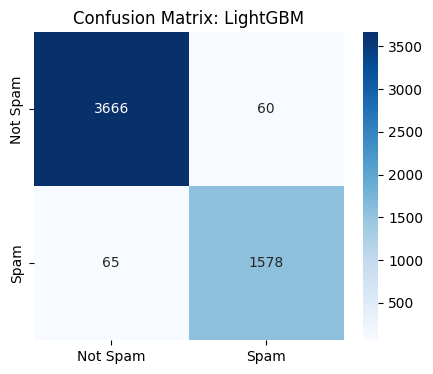

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam','Spam'], yticklabels=['Not Spam','Spam'])
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

In [20]:
model_dir = "model"
import os; os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_pipeline.named_steps['clf'], f"{model_dir}/best_spam_model.pkl")
joblib.dump(best_pipeline.named_steps['tfidf'], f"{model_dir}/tfidf_vectorizer.pkl")

print(f"\n💾 Saved best model: {best_model_name}")
print("✅ Model saved to model/best_spam_model.pkl")
print("✅ TF-IDF saved to model/tfidf_vectorizer.pkl")


💾 Saved best model: LightGBM
✅ Model saved to model/best_spam_model.pkl
✅ TF-IDF saved to model/tfidf_vectorizer.pkl
